In [40]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
df = pd.read_csv('FROG_2025-04-29 00_00_00+00_00.csv')
df.info()
df['mid'] = (df['ask_px_00'] + df['bid_px_00'])/2
ask_prices = df[['ask_px_00','ask_px_01','ask_px_02','ask_px_03','ask_px_04','ask_px_05','ask_px_06','ask_px_07','ask_px_08','ask_px_09']]
ask_sizes = df[['ask_sz_00', 'ask_sz_01', 'ask_sz_02', 'ask_sz_03', 'ask_sz_04', 
                'ask_sz_05', 'ask_sz_06', 'ask_sz_07', 'ask_sz_08', 'ask_sz_09']]
i = 0
px = ask_prices.iloc[i].values
sz = ask_sizes.iloc[i].values
mid = df['mid'].iloc[i]
order_size = np.arange(10,400,10)
slippages = []
for x in order_size:
    remaining =x
    total_cost = 0 
    for (price,size) in zip(px,sz):
        av = min(remaining,size)
        total_cost +=av*price
        remaining-=av
        if remaining<=0:
            break
    if remaining>0:
        slippages.append(np.nan)
    else:
        slippages.append(total_cost/x - mid)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22838 entries, 0 to 22837
Data columns (total 74 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ts_event       22838 non-null  object 
 1   ts_event.1     22838 non-null  object 
 2   rtype          22838 non-null  int64  
 3   publisher_id   22838 non-null  int64  
 4   instrument_id  22838 non-null  int64  
 5   action         22838 non-null  object 
 6   side           22838 non-null  object 
 7   depth          22838 non-null  int64  
 8   price          22838 non-null  float64
 9   size           22838 non-null  int64  
 10  flags          22838 non-null  int64  
 11  ts_in_delta    22838 non-null  int64  
 12  sequence       22838 non-null  int64  
 13  bid_px_00      22838 non-null  float64
 14  ask_px_00      22838 non-null  float64
 15  bid_sz_00      22838 non-null  int64  
 16  ask_sz_00      22838 non-null  int64  
 17  bid_ct_00      22838 non-null  int64  
 18  ask_ct

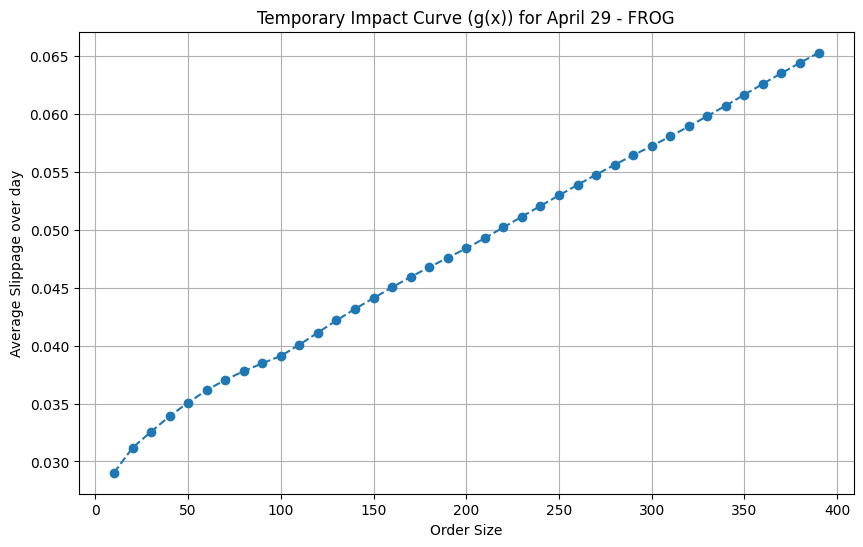

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('FROG_2025-04-29 00_00_00+00_00.csv')
df['mid'] = (df['ask_px_00'] + df['bid_px_00']) / 2

ask_prices = df[['ask_px_00','ask_px_01','ask_px_02','ask_px_03','ask_px_04',
                 'ask_px_05','ask_px_06','ask_px_07','ask_px_08','ask_px_09']]
ask_sizes = df[['ask_sz_00', 'ask_sz_01', 'ask_sz_02', 'ask_sz_03', 'ask_sz_04', 
                'ask_sz_05', 'ask_sz_06', 'ask_sz_07', 'ask_sz_08', 'ask_sz_09']]

order_size = np.arange(10, 400, 10)
all_slippages = []

for i in range(len(df)):
    px = ask_prices.iloc[i].values
    sz = ask_sizes.iloc[i].values
    mid = df['mid'].iloc[i]

    slippages = []
    for x in order_size:
        remaining = x
        total_cost = 0
        for price, size in zip(px, sz):
            av = min(remaining, size)
            total_cost += av * price
            remaining -= av
            if remaining <= 0:
                break
        if remaining > 0:
            slippages.append(np.nan)
        else:
            slippages.append(total_cost / x - mid)
    
    all_slippages.append(slippages)

# Convert to NumPy array for easier math
all_slippages = np.array(all_slippages)
mean_slippage = np.nanmean(all_slippages, axis=0)

# Plot mean slippage curve
plt.figure(figsize=(10, 6))
plt.plot(order_size, mean_slippage, marker='o', linestyle='--')
plt.xlabel('Order Size')
plt.ylabel('Average Slippage over day')
plt.grid(True)
plt.title('Temporary Impact Curve (g(x)) for April 29 - FROG')
plt.show()

# Save for model fitting later
out_df = pd.DataFrame({
    'order_size': order_size,
    'mean_slippage': mean_slippage
})
out_df.to_csv('frog_gt_apr29.csv', index=False)


In [42]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

folder_path = 'FROG'

csv_out_dir = 'impact_curves/FROG'
plot_out_dir = 'impact_plots/FROG'
os.makedirs(csv_out_dir, exist_ok=True)
os.makedirs(plot_out_dir, exist_ok=True)
order_size = np.arange(10, 400, 10)
file_list = sorted([f for f in os.listdir(folder_path) if f.endswith('.csv')])
for file in file_list:
    try:
        full_path = os.path.join(folder_path, file)
        df = pd.read_csv(full_path)

        date_str = file.split('_')[1]

        df['mid'] = (df['ask_px_00'] + df['bid_px_00']) / 2

        ask_prices = df[[f'ask_px_0{i}' for i in range(10)]]
        ask_sizes = df[[f'ask_sz_0{i}' for i in range(10)]]

        all_slippages = []

        for i in range(len(df)):
            px = ask_prices.iloc[i].values
            sz = ask_sizes.iloc[i].values
            mid = df['mid'].iloc[i]

            slippages = []
            for x in order_size:
                remaining = x
                total_cost = 0
                for price, size in zip(px, sz):
                    av = min(remaining, size)
                    total_cost += av * price
                    remaining -= av
                    if remaining <= 0:
                        break
                if remaining > 0:
                    slippages.append(np.nan)
                else:
                    slippages.append(total_cost / x - mid)

            all_slippages.append(slippages)

        all_slippages = np.array(all_slippages)
        mean_slippage = np.nanmean(all_slippages, axis=0)
        out_csv = os.path.join(csv_out_dir, f'{date_str}.csv')
        pd.DataFrame({
            'order_size': order_size,
            'mean_slippage': mean_slippage
        }).to_csv(out_csv, index=False)
        plt.figure(figsize=(10, 6))
        plt.plot(order_size, mean_slippage, marker='o', linestyle='--', color='blue')
        plt.xlabel('Order Size')
        plt.ylabel('Average Slippage')
        plt.title(f'Temporary Impact Curve - FROG ({date_str})')
        plt.grid(True)
        out_plot = os.path.join(plot_out_dir, f'{date_str}.png')
        plt.savefig(out_plot)
        plt.close()
        print(f"Processed: {file} ✅")
    except Exception as e:
        print(f"Error processing {file}: {e}")


Processed: FROG_2025-04-03 00_00_00+00_00.csv ✅
Processed: FROG_2025-04-04 00_00_00+00_00.csv ✅
Processed: FROG_2025-04-07 00_00_00+00_00.csv ✅
Processed: FROG_2025-04-08 00_00_00+00_00.csv ✅
Processed: FROG_2025-04-09 00_00_00+00_00.csv ✅
Processed: FROG_2025-04-10 00_00_00+00_00.csv ✅
Processed: FROG_2025-04-11 00_00_00+00_00.csv ✅
Processed: FROG_2025-04-14 00_00_00+00_00.csv ✅
Processed: FROG_2025-04-15 00_00_00+00_00.csv ✅
Processed: FROG_2025-04-16 00_00_00+00_00.csv ✅
Processed: FROG_2025-04-17 00_00_00+00_00.csv ✅
Processed: FROG_2025-04-21 00_00_00+00_00.csv ✅
Processed: FROG_2025-04-22 00_00_00+00_00.csv ✅
Processed: FROG_2025-04-23 00_00_00+00_00.csv ✅
Processed: FROG_2025-04-24 00_00_00+00_00.csv ✅
Processed: FROG_2025-04-25 00_00_00+00_00.csv ✅
Processed: FROG_2025-04-28 00_00_00+00_00.csv ✅
Processed: FROG_2025-04-29 00_00_00+00_00.csv ✅


KeyboardInterrupt: 

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def process_lob_folder(folder_path, ticker_name, output_dir='gt_outputs'):
    os.makedirs(f'{output_dir}/{ticker_name}/csv', exist_ok=True)
    os.makedirs(f'{output_dir}/{ticker_name}/plots', exist_ok=True)

    files = sorted([f for f in os.listdir(folder_path) if f.endswith('.csv')])
    order_size = np.arange(10, 400, 10)

    for file in files:
        try:
            df = pd.read_csv(os.path.join(folder_path, file))
            df['mid'] = (df['ask_px_00'] + df['bid_px_00']) / 2

            ask_prices = df[[f'ask_px_0{i}' for i in range(10)]]
            ask_sizes = df[[f'ask_sz_0{i}' for i in range(10)]]

            all_slippages = []
            for i in range(len(df)):
                px = ask_prices.iloc[i].values
                sz = ask_sizes.iloc[i].values
                mid = df['mid'].iloc[i]

                slippages = []
                for x in order_size:
                    remaining = x
                    total_cost = 0
                    for price, size in zip(px, sz):
                        av = min(remaining, size)
                        total_cost += av * price
                        remaining -= av
                        if remaining <= 0:
                            break
                    if remaining > 0:
                        slippages.append(np.nan)
                    else:
                        slippages.append(total_cost / x - mid)
                all_slippages.append(slippages)

            all_slippages = np.array(all_slippages)
            mean_slippage = np.nanmean(all_slippages, axis=0)

            # Save CSV
            date_str = file.split('_')[1][:10]
            out_df = pd.DataFrame({
                'order_size': order_size,
                'mean_slippage': mean_slippage
            })
            out_df.to_csv(f'{output_dir}/{ticker_name}/csv/{ticker_name}_gt_{date_str}.csv', index=False)

            # Save plot
            plt.figure(figsize=(10, 6))
            plt.plot(order_size, mean_slippage, marker='o', linestyle='--')
            plt.xlabel('Order Size')
            plt.ylabel('Average Slippage')
            plt.title(f'{ticker_name} Temporary Impact Curve - {date_str}')
            plt.grid(True)
            plt.tight_layout()
            plt.savefig(f'{output_dir}/{ticker_name}/plots/{ticker_name}_gt_{date_str}.png')
            plt.close()

            print(f"Processed: {file} ✅")

        except Exception as e:
            print(f"⚠️ Error processing {file}: {e}")

# Run for SOUN and CRWV
process_lob_folder('SOUN', 'SOUN')
process_lob_folder('CRWV', 'CRWV')


In [ ]:
# import os
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

# # FROG data
# folder_path = 'FROG'
# ticker_name = 'FROG'

# csv_out_dir = f'gt_outputs/{ticker_name}/csv'
# plot_out_dir = f'gt_outputs/{ticker_name}/plots'

# os.makedirs(csv_out_dir, exist_ok=True)
# os.makedirs(plot_out_dir, exist_ok=True)

# order_size = np.arange(10, 400, 10)
# file_list = sorted([f for f in os.listdir(folder_path) if f.endswith('.csv')])

# for file in file_list:
#     try:
#         full_path = os.path.join(folder_path, file)
#         df = pd.read_csv(full_path)

#         # Extract date string like 2025-04-03
#         date_str = file.split('_')[1]

#         df['mid'] = (df['ask_px_00'] + df['bid_px_00']) / 2

#         ask_prices = df[[f'ask_px_0{i}' for i in range(10)]]
#         ask_sizes = df[[f'ask_sz_0{i}' for i in range(10)]]

#         all_slippages = []

#         for i in range(len(df)):
#             px = ask_prices.iloc[i].values
#             sz = ask_sizes.iloc[i].values
#             mid = df['mid'].iloc[i]

#             slippages = []
#             for x in order_size:
#                 remaining = x
#                 total_cost = 0
#                 for price, size in zip(px, sz):
#                     av = min(remaining, size)
#                     total_cost += av * price
#                     remaining -= av
#                     if remaining <= 0:
#                         break
#                 if remaining > 0:
#                     slippages.append(np.nan)
#                 else:
#                     slippages.append(total_cost / x - mid)

#             all_slippages.append(slippages)

#         all_slippages = np.array(all_slippages)
#         mean_slippage = np.nanmean(all_slippages, axis=0)

#         # Save CSV
#         out_csv = os.path.join(csv_out_dir, f'{ticker_name}_gt_{date_str}.csv')
#         pd.DataFrame({
#             'order_size': order_size,
#             'mean_slippage': mean_slippage
#         }).to_csv(out_csv, index=False)

#         # Save plot
#         plt.figure(figsize=(10, 6))
#         plt.plot(order_size, mean_slippage, marker='o', linestyle='--', color='blue')
#         plt.xlabel('Order Size')
#         plt.ylabel('Average Slippage')
#         plt.title(f'{ticker_name} Temporary Impact Curve - {date_str}')
#         plt.grid(True)
#         plt.tight_layout()
#         out_plot = os.path.join(plot_out_dir, f'{ticker_name}_gt_{date_str}.png')
#         plt.savefig(out_plot)
#         plt.close()

#         print(f"Processed: {file} ✅")

#     except Exception as e:
#         print(f"⚠️ Error processing {file}: {e}")


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import re
from datetime import datetime

# Choose stock
ticker = "FROG"
csv_folder = f"gt_outputs/{ticker}/csv"
plot_folder = f"gt_models/{ticker}/plots"
os.makedirs(plot_folder, exist_ok=True)

summary_rows = []

# --- Define Models ---
def linear(x, a):
    return a * x

def quadratic(x, a, b):
    return a * x + b * x**2

def power_law(x, a, b):
    return a * x ** b

# --- Process Each Day's File ---
file_list = sorted([f for f in os.listdir(csv_folder) if f.endswith('.csv')])
for file in file_list:
    try:
        df = pd.read_csv(os.path.join(csv_folder, file))
        x = df['order_size'].values
        y = df['mean_slippage'].values

        mask = ~np.isnan(y)
        x = x[mask]
        y = y[mask]

        # Linear Fit
        popt_lin, _ = curve_fit(linear, x, y)

        # Quadratic Fit
        popt_quad, _ = curve_fit(quadratic, x, y)

        # Power-law Fit
        log_x = np.log(x)
        log_y = np.log(y)
        popt_pow = np.polyfit(log_x, log_y, 1)
        a_pow = np.exp(popt_pow[1])
        b_pow = popt_pow[0]

        # Predicted curves
        y_lin = linear(x, *popt_lin)
        y_quad = quadratic(x, *popt_quad)
        y_pow = power_law(x, a_pow, b_pow)

        # Plot
        plt.figure(figsize=(10, 6))
        plt.scatter(x, y, label='Observed', color='black')
        plt.plot(x, y_lin, label=f'Linear: a={popt_lin[0]:.4f}', color='blue')
        plt.plot(x, y_quad, label=f'Quadratic: a={popt_quad[0]:.4f}, b={popt_quad[1]:.4f}', color='green')
        plt.plot(x, y_pow, label=f'Power: a={a_pow:.4f}, b={b_pow:.4f}', color='red')
        plt.title(f'{ticker} Model Fits - {file}')
        plt.xlabel('Order Size')
        plt.ylabel('Mean Slippage')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(os.path.join(plot_folder, file.replace('.csv', '.png')))
        plt.close()

        # Extract date using regex
        match = re.search(r'(\d{4}-\d{2}-\d{2})', file)
        if match:
            date_str = match.group(1)
            date_obj = datetime.strptime(date_str, "%Y-%m-%d")
        else:
            raise ValueError("Date not found in filename")

        summary_rows.append({
            'date': date_obj,
            'a_linear': popt_lin[0],
            'a_quad': popt_quad[0],
            'b_quad': popt_quad[1],
            'a_power': a_pow,
            'b_power': b_pow
        })

        print(f"✅ Fit done for: {file}")

    except Exception as e:
        print(f"⚠️ Fit failed for {file}: {e}")

# --- Save Fit Parameters ---
summary_df = pd.DataFrame(summary_rows)
summary_df.sort_values(by="date", inplace=True)
summary_df.to_csv(f'gt_models/{ticker}/fit_params.csv', index=False)
print(f"📄 All model parameters saved to gt_models/{ticker}/fit_params.csv")


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Choose stock
ticker = "SOUN"
csv_folder = f"gt_outputs/{ticker}/csv"
plot_folder = f"gt_models/{ticker}/plots"
os.makedirs(plot_folder, exist_ok=True)

summary_rows = []

# --- Define Models ---

def linear(x, a):
    return a * x

def quadratic(x, a, b):
    return a * x + b * x**2

def power_law(x, a, b):
    return a * x ** b

# --- Process Each Day's File ---

file_list = sorted([f for f in os.listdir(csv_folder) if f.endswith('.csv')])
for file in file_list:
    try:
        df = pd.read_csv(os.path.join(csv_folder, file))
        x = df['order_size'].values
        y = df['mean_slippage'].values

        mask = ~np.isnan(y)
        x = x[mask]
        y = y[mask]

        # Linear Fit
        popt_lin, _ = curve_fit(linear, x, y)

        # Quadratic Fit
        popt_quad, _ = curve_fit(quadratic, x, y)

        # Power-law Fit
        log_x = np.log(x)
        log_y = np.log(y)
        popt_pow = np.polyfit(log_x, log_y, 1)  # slope=b, intercept=log(a)
        a_pow = np.exp(popt_pow[1])
        b_pow = popt_pow[0]

        # Predicted curves
        y_lin = linear(x, *popt_lin)
        y_quad = quadratic(x, *popt_quad)
        y_pow = power_law(x, a_pow, b_pow)

        # Plot
        plt.figure(figsize=(10, 6))
        plt.scatter(x, y, label='Observed', color='black')
        plt.plot(x, y_lin, label=f'Linear: a={popt_lin[0]:.4f}', color='blue')
        plt.plot(x, y_quad, label=f'Quadratic: a={popt_quad[0]:.4f}, b={popt_quad[1]:.4f}', color='green')
        plt.plot(x, y_pow, label=f'Power: a={a_pow:.4f}, b={b_pow:.4f}', color='red')
        plt.title(f'{ticker} Model Fits - {file[-14:-4]}')
        plt.xlabel('Order Size')
        plt.ylabel('Mean Slippage')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(os.path.join(plot_folder, file.replace('.csv', '.png')))
        plt.close()

        # Save summary row
        summary_rows.append({
            'date': file[-14:-4],
            'a_linear': popt_lin[0],
            'a_quad': popt_quad[0],
            'b_quad': popt_quad[1],
            'a_power': a_pow,
            'b_power': b_pow
        })

        print(f"✅ Fit done for: {file}")

    except Exception as e:
        print(f"⚠️ Fit failed for {file}: {e}")

# --- Save Fit Parameters ---
summary_df = pd.DataFrame(summary_rows)
summary_df.to_csv(f'gt_models/{ticker}/fit_params.csv', index=False)
print(f"📄 All model parameters saved to gt_models/{ticker}/fit_params.csv")


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Choose stock
ticker = "CRWV"
csv_folder = f"gt_outputs/{ticker}/csv"
plot_folder = f"gt_models/{ticker}/plots"
os.makedirs(plot_folder, exist_ok=True)

summary_rows = []

# --- Define Models ---

def linear(x, a):
    return a * x

def quadratic(x, a, b):
    return a * x + b * x**2

def power_law(x, a, b):
    return a * x ** b

# --- Process Each Day's File ---

file_list = sorted([f for f in os.listdir(csv_folder) if f.endswith('.csv')])
for file in file_list:
    try:
        df = pd.read_csv(os.path.join(csv_folder, file))
        x = df['order_size'].values
        y = df['mean_slippage'].values

        mask = ~np.isnan(y)
        x = x[mask]
        y = y[mask]

        # Linear Fit
        popt_lin, _ = curve_fit(linear, x, y)

        # Quadratic Fit
        popt_quad, _ = curve_fit(quadratic, x, y)

        # Power-law Fit
        log_x = np.log(x)
        log_y = np.log(y)
        popt_pow = np.polyfit(log_x, log_y, 1)  # slope=b, intercept=log(a)
        a_pow = np.exp(popt_pow[1])
        b_pow = popt_pow[0]

        # Predicted curves
        y_lin = linear(x, *popt_lin)
        y_quad = quadratic(x, *popt_quad)
        y_pow = power_law(x, a_pow, b_pow)

        # Plot
        plt.figure(figsize=(10, 6))
        plt.scatter(x, y, label='Observed', color='black')
        plt.plot(x, y_lin, label=f'Linear: a={popt_lin[0]:.4f}', color='blue')
        plt.plot(x, y_quad, label=f'Quadratic: a={popt_quad[0]:.4f}, b={popt_quad[1]:.4f}', color='green')
        plt.plot(x, y_pow, label=f'Power: a={a_pow:.4f}, b={b_pow:.4f}', color='red')
        plt.title(f'{ticker} Model Fits - {file[-14:-4]}')
        plt.xlabel('Order Size')
        plt.ylabel('Mean Slippage')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(os.path.join(plot_folder, file.replace('.csv', '.png')))
        plt.close()

        # Save summary row
        summary_rows.append({
            'date': file[-14:-4],
            'a_linear': popt_lin[0],
            'a_quad': popt_quad[0],
            'b_quad': popt_quad[1],
            'a_power': a_pow,
            'b_power': b_pow
        })

        print(f"✅ Fit done for: {file}")

    except Exception as e:
        print(f"⚠️ Fit failed for {file}: {e}")

# --- Save Fit Parameters ---
summary_df = pd.DataFrame(summary_rows)
summary_df.to_csv(f'gt_models/{ticker}/fit_params.csv', index=False)
print(f"📄 All model parameters saved to gt_models/{ticker}/fit_params.csv")



FROG Columns: ['date', 'a_linear', 'a_quad', 'b_quad', 'a_power', 'b_power']

SOUN Columns: ['date', 'a_linear', 'a_quad', 'b_quad', 'a_power', 'b_power']

CRWV Columns: ['date', 'a_linear', 'a_quad', 'b_quad', 'a_power', 'b_power']
✅ Loaded: FROG (21 days)
✅ Loaded: SOUN (21 days)
✅ Loaded: CRWV (21 days)

🔍 FROG 'date' column sample:
0   2025-04-03
1   2025-04-04
2   2025-04-07
Name: date, dtype: datetime64[ns]

🔍 SOUN 'date' column sample:
0   2025-04-03
1   2025-04-04
2   2025-04-07
Name: date, dtype: datetime64[ns]

🔍 CRWV 'date' column sample:
0   2025-04-03
1   2025-04-04
2   2025-04-07
Name: date, dtype: datetime64[ns]

📊 Plotting for FROG


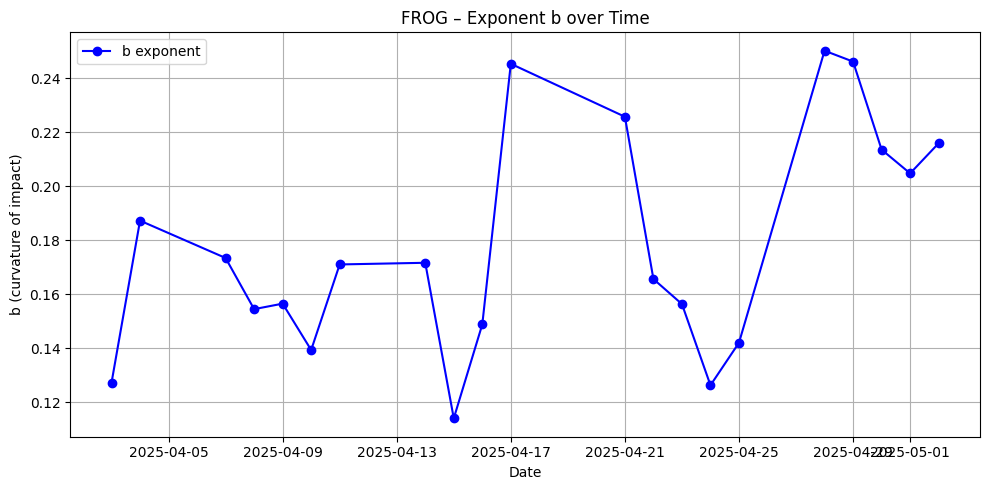

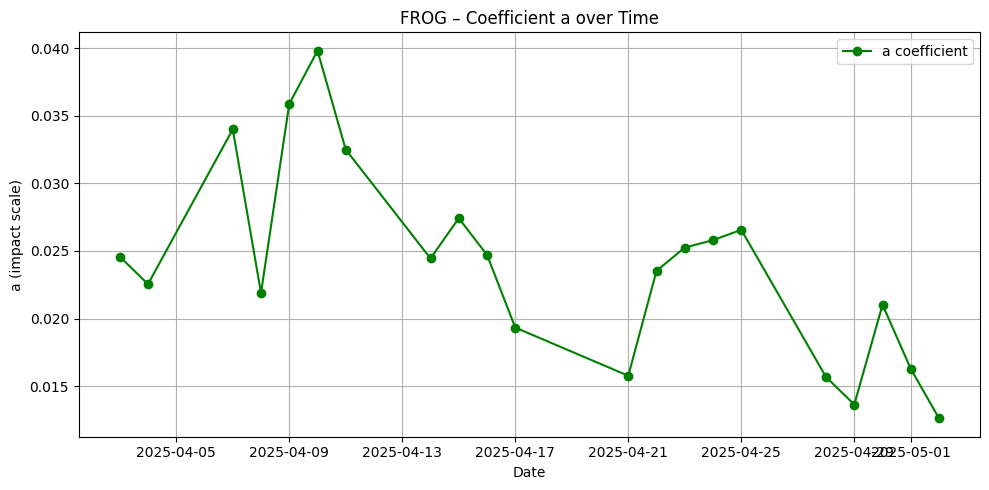


📊 Plotting for SOUN


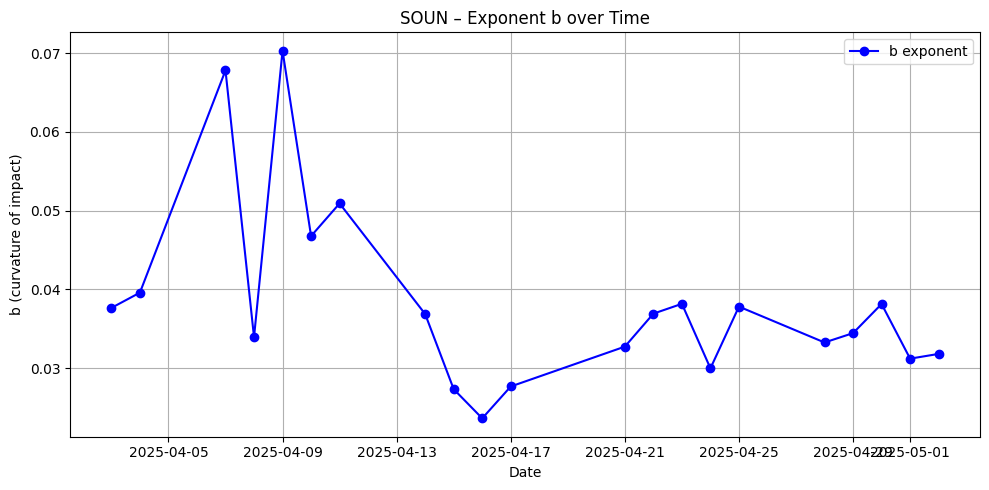

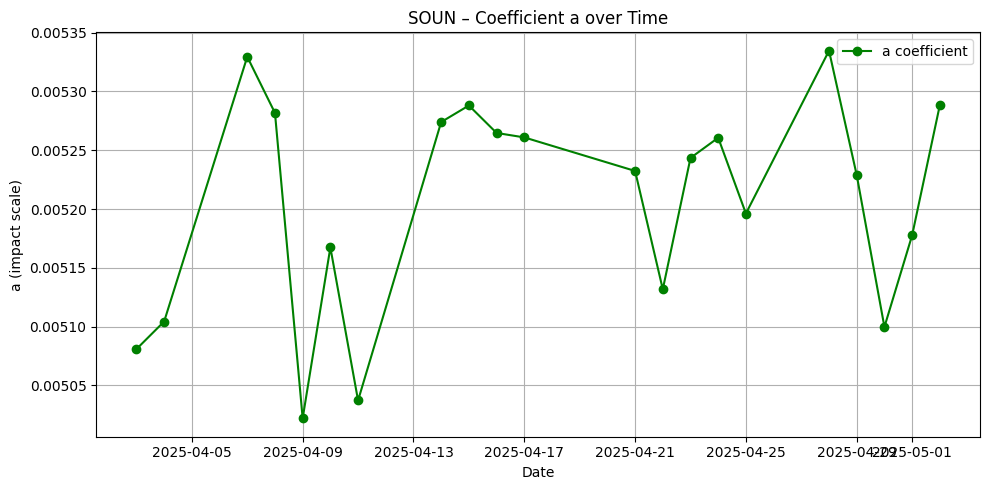


📊 Plotting for CRWV


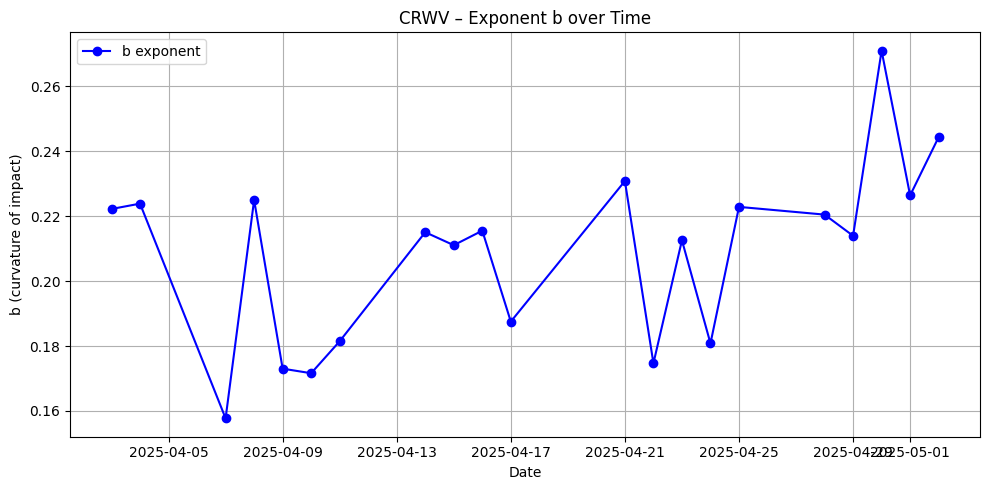

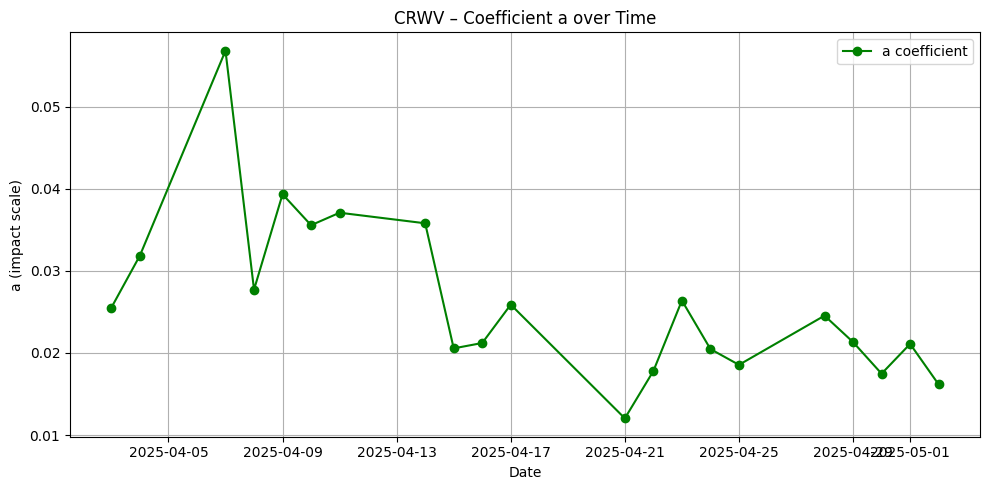

In [47]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Set base folder where gt_models are stored
base_folder = "gt_models"

# List of stock tickers you worked with
tickers = ["FROG", "SOUN", "CRWV"]
# Check what columns exist in each ticker’s fit_params.csv
for ticker in tickers:
    df = fit_data[ticker]
    print(f"\n{ticker} Columns:", df.columns.tolist())

# Create a dictionary to store each ticker's dataframe
fit_data = {}

# Load all fit_param.csv files
for ticker in tickers:
    file_path = os.path.join(base_folder, ticker, "fit_params.csv")
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        df['date'] = pd.to_datetime(df['date'])
        fit_data[ticker] = df
        print(f"✅ Loaded: {ticker} ({len(df)} days)")
    else:
        print(f"❌ File not found for: {ticker}")

# Function to plot b_power over time
def plot_b_power(df, ticker):
    plt.figure(figsize=(10, 5))
    plt.plot(df['date'], df['b_power'], marker='o', label='b exponent')
    plt.axhline(1, color='gray', linestyle='--', label='Linear reference (b = 1)')
    plt.title(f'{ticker} – Power Exponent b over Time')
    plt.xlabel('Date')
    plt.ylabel('Power Exponent b')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

import matplotlib.pyplot as plt

def plot_b_power(df, ticker):
    if 'b_power' not in df.columns:
        print(f"⚠️ Skipping 'b' plot for {ticker} – column 'b_power' not found")
        return
    plt.figure(figsize=(10, 5))
    plt.plot(df['date'], df['b_power'], marker='o', color='blue', label='b exponent')
    plt.title(f'{ticker} – Exponent b over Time')
    plt.xlabel('Date')
    plt.ylabel('b (curvature of impact)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_a_power(df, ticker):
    if 'a_power' not in df.columns:
        print(f"⚠️ Skipping 'a' plot for {ticker} – column 'a_power' not found")
        return
    plt.figure(figsize=(10, 5))
    plt.plot(df['date'], df['a_power'], marker='o', color='green', label='a coefficient')
    plt.title(f'{ticker} – Coefficient a over Time')
    plt.xlabel('Date')
    plt.ylabel('a (impact scale)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
for ticker in tickers:
    df = fit_data[ticker]
    print(f"\n🔍 {ticker} 'date' column sample:")
    print(df['date'].head(3))

for ticker in tickers:
    df = fit_data[ticker]
    # 🔧 Parse the 'date' column properly
    df['date'] = pd.to_datetime(df['date'])

    print(f"\n📊 Plotting for {ticker}")
    plot_b_power(df, ticker)
    plot_a_power(df, ticker)




In [43]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

def compute_rmse_models(base_folder, tickers):
    results = {}

    for ticker in tickers:
        print(f"\n🔍 Processing {ticker}")
        fit_file = os.path.join(base_folder, ticker, "fit_params.csv")
        data_file = os.path.join(base_folder, ticker, "daily_impact_data.csv")

        if not (os.path.exists(fit_file) and os.path.exists(data_file)):
            print(f"❌ Missing files for {ticker}")
            continue

        fit_df = pd.read_csv(fit_file, parse_dates=['date'])
        data_df = pd.read_csv(data_file, parse_dates=['date'])

        model_errors = {'linear': [], 'quadratic': [], 'power': []}

        for date in fit_df['date'].unique():
            fit_row = fit_df[fit_df['date'] == date]
            data_day = data_df[data_df['date'] == date]

            if fit_row.empty or data_day.empty:
                continue

            x = data_day['x_volume'].values
            y_true = data_day['impact'].values

            # Get fitted coefficients
            a_quad = fit_row['a_quad'].values[0]
            b_quad = fit_row['b_quad'].values[0]

            b_lin = fit_row['b_linear'].values[0]

            a_pow = fit_row['a_power'].values[0]
            b_pow = fit_row['b_power'].values[0]

            # Predicted values
            y_linear = b_lin * x
            y_quad = a_quad * x**2 + b_quad * x
            y_power = a_pow * x**b_pow

            # Compute RMSEs
            model_errors['linear'].append(np.sqrt(mean_squared_error(y_true, y_linear)))
            model_errors['quadratic'].append(np.sqrt(mean_squared_error(y_true, y_quad)))
            model_errors['power'].append(np.sqrt(mean_squared_error(y_true, y_power)))

        # Average RMSE across all days
        avg_errors = {model: np.mean(rmses) for model, rmses in model_errors.items()}
        results[ticker] = avg_errors

        print(f"📊 Avg RMSE for {ticker}:")
        for model, error in avg_errors.items():
            print(f"  {model.ljust(10)}: {error:.4f}")

    return results


In [45]:
import os
import pandas as pd

def combine_gt_csvs(ticker, input_dir='gt_outputs', output_csv='daily_impact_data.csv'):
    combined_data = []

    folder = f'{input_dir}/{ticker}/csv'
    files = sorted([f for f in os.listdir(folder) if f.endswith('.csv')])

    for file in files:
        try:
            df = pd.read_csv(os.path.join(folder, file))
            date_str = file.split('_gt_')[1].split('.csv')[0]
            df['date'] = date_str
            df['ticker'] = ticker
            df.rename(columns={'order_size': 'x', 'mean_slippage': 'gx'}, inplace=True)
            combined_data.append(df[['date', 'x', 'gx', 'ticker']])
        except Exception as e:
            print(f"Error in {file}: {e}")

    final_df = pd.concat(combined_data, ignore_index=True)
    final_df.to_csv(output_csv, index=False)
    print(f"✅ Combined data saved to: {output_csv}")

# Example for SOUN and CRWV
combine_gt_csvs('SOUN')
combine_gt_csvs('CRWV')
combine_gt_csvs('FROG')  # if you’ve also done FROG


✅ Combined data saved to: daily_impact_data.csv
✅ Combined data saved to: daily_impact_data.csv
✅ Combined data saved to: daily_impact_data.csv


In [46]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

# Load
daily_df = pd.read_csv('daily_impact_data.csv')
fit_params = pd.read_csv('gt_models/FROG/fit_params.csv')  # ✅ Correct path

# 🔧 Clean dates: Remove " 00" and convert to date format
daily_df['date'] = pd.to_datetime(daily_df['date'].str[:10]).dt.date
fit_params['date'] = pd.to_datetime(fit_params['date']).dt.date

# ✅ Inject ticker
daily_df['ticker'] = 'FROG'
fit_params['ticker'] = 'FROG'

# Merge
merged = pd.merge(daily_df, fit_params, on=['date', 'ticker'])
print("✅ Merged shape:", merged.shape)

# Compute predicted g(x) for each model
merged['g_linear'] = merged['a_linear'] * merged['x']
merged['g_quad'] = merged['a_quad'] * merged['x'] + merged['b_quad'] * (merged['x'] ** 2)
merged['g_power'] = merged['a_power'] * (merged['x'] ** merged['b_power'])

# Drop any rows where actual or predicted g(x) is missing
merged = merged.dropna(subset=['gx', 'g_linear', 'g_quad', 'g_power'])

# Compute RMSE for each model
rmse_linear = np.sqrt(mean_squared_error(merged['gx'], merged['g_linear']))
rmse_quad = np.sqrt(mean_squared_error(merged['gx'], merged['g_quad']))
rmse_power = np.sqrt(mean_squared_error(merged['gx'], merged['g_power']))

# Print results
print("\n📊 RMSE Comparison for FROG:")
print(f"📉 Linear Model:    {rmse_linear:.6f}")
print(f"📈 Quadratic Model: {rmse_quad:.6f}")
print(f"⚡ Power Model:     {rmse_power:.6f}")


✅ Merged shape: (819, 9)

📊 RMSE Comparison for FROG:
📉 Linear Model:    0.021070
📈 Quadratic Model: 0.013604
⚡ Power Model:     0.003053


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import mean_squared_error

# --- Configure paths ---
tickers = ['FROG', 'SOUN', 'CRWV']
daily_data_path = 'daily_impact_data.csv'
fit_params_dir = 'gt_models'
plot_output_dir = 'plots'

# --- Load combined daily data ---
daily_df = pd.read_csv(daily_data_path)
daily_df['date'] = pd.to_datetime(daily_df['date'].str[:10]).dt.date

# --- Loop through each stock ---
for ticker in tickers:
    print(f"📈 Processing {ticker}...")

    # Load model params
    params_path = f"{fit_params_dir}/{ticker}/fit_params.csv"
    if not os.path.exists(params_path):
        print(f"⚠️ Missing file for {ticker}: {params_path}")
        continue

    params = pd.read_csv(params_path)
    params['date'] = pd.to_datetime(params['date']).dt.date
    params['ticker'] = ticker

    # Filter daily data for ticker
    ticker_df = daily_df.copy()
    ticker_df['ticker'] = ticker

    # Merge
    merged = pd.merge(ticker_df, params, on=['date', 'ticker'])
    merged.dropna(subset=['gx', 'x'], inplace=True)

    # Compute predictions
    merged['g_linear'] = merged['a_linear'] * merged['x']
    merged['g_quad'] = merged['a_quad'] * merged['x'] + merged['b_quad'] * (merged['x'] ** 2)
    merged['g_power'] = merged['a_power'] * (merged['x'] ** merged['b_power'])

    # Create output folder
    ticker_plot_dir = os.path.join(plot_output_dir, ticker)
    os.makedirs(ticker_plot_dir, exist_ok=True)

    # Plot per day
    for day, group in merged.groupby('date'):
        plt.figure(figsize=(8, 5))
        plt.scatter(group['x'], group['gx'], label='Actual gx', color='black', alpha=0.6)

        # Plot predictions
        plt.plot(group['x'], group['g_linear'], label='Linear', linestyle='--', color='blue')
        plt.plot(group['x'], group['g_quad'], label='Quadratic', linestyle='-.', color='orange')
        plt.plot(group['x'], group['g_power'], label='Power-law', linestyle='-', color='green')

        # Title and labels
        plt.title(f'{ticker} - {day}')
        plt.xlabel('x (Executed Volume Share)')
        plt.ylabel('g(x) (Temporary Impact)')
        plt.legend()
        plt.grid(True)

        # Save plot
        filename = os.path.join(ticker_plot_dir, f'{day}.png')
        plt.tight_layout()
        plt.savefig(filename)
        plt.close()

    print(f"✅ Saved plots for {ticker} in {ticker_plot_dir}")
